# Capstone Project for Coursera
This notebook will be mainly used for capstone project of Coursera online certificate for **IBM Data Science Professional Ceritificate**.

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

This project is focus on starting a new restaurant business in Toronto area. By using **k-means clustering method** we can use venues information from Foursquare and filtering the most popular venues in each borough. According to the detail information we can choose the location for new restaurant business.

## Data <a name="data"></a>

The dataset for this capstone project consists of neighborhood information of Toronto obtained from Wikipedia website: [List of postal codes of Canada: M](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M). By using the BeautifulSoup package of Python, transforming the website data to pandas data frame which include postcode, borough, and neighborhood features. Then according to the transformed data frame obtained latitude and longitude by applying geopy package. Then using the latitude and longitude we can collect venues near each neighborhood for cluster analysis by using Foursquare API.

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


### Import Libraries

First import the libraries which will be used in this capstone project.

In [2]:
import json

# !conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm

from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes
import folium
print('Libraries imported.')

Libraries imported.


### Import Data

Next, using **BeautifulSoup** to transform the data in the table on the Wikipedia page into pandas dataframe. At the same time, cleanning dataframe as the requirement stated.

In [3]:
from bs4 import BeautifulSoup

with open('List of postal codes of Canada_ M - Wikipedia.html') as html_file:
    soup = BeautifulSoup(html_file, 'lxml')


In [4]:
table = soup.find('table', class_='wikitable sortable')
table_rows = table.find_all("tr")
table_columns = table.find_all("th")
l = []
for tr in table_rows:
    td = tr.find_all("td")
    row = [tr.text for tr in td]
    if row and row[1] != 'Not assigned':
        if row[2] == 'Not assigned\n':
            row[2] = row[1]
        l.append(row)
cols = [c.text.replace('\n', '') for c in table_columns]
df = pd.DataFrame(l, columns=cols).replace('\n', '', regex=True)
df = df.groupby(['Borough', 'Postcode'], sort=False).agg(lambda x: ', '.join(set(x.dropna()))).reset_index()
df = df[cols].replace('\n', '', regex=True)
df.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Queen's Park


In [5]:
df.shape

(103, 3)

As the result of **shape** method, the size of this transformed table is **(103, 3)**.

Next step is add the **Latitude** and **Longitude** to the dataframe.

In [6]:
ll = pd.read_csv('Geospatial_Coordinates.csv')
ll.columns = ['Postcode', 'Latitude', 'Longitude']
cols = ['Postcode']
df_withll = df.join(ll.set_index(cols), on=cols)

### Use geopy library to get the latitude and longitude values of Toronto

In [7]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ca_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


### Create a map of Ontario with neighborhoods superimposed on top

Create map of Toronto using latitude and longitude values, and then add markers to map

In [8]:

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_withll['Latitude'], df_withll['Longitude'], df_withll['Borough'], df_withll['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Then filtering the **Borough** by contains **Toronto**

In [9]:
df_tor = df_withll[df_withll['Borough'].str.contains("Toronto")]
df_tor.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


Creating map of Toronto using only Borough that contains Toronto.

In [10]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_tor['Latitude'], df_tor['Longitude'], df_tor['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

## Methodology <a name="methodology"></a>

1. Exploratory Data Analysis

   Exploratory data analysis was used to analyze data sets to summarize their main    characteristics, and visual data sets.
   
   First, transforming online data table to Pandas data frame. Using Pandas command to eliminate missing values.
   
   Use Geopy package to obtain the latitude and longitude of Toronto, then mapping table point on Toronto area. Thus, we can visualize data point on map.

2. Segmenting and Slicing, and dimensional reduction

   Cluster analysis is the task of grouping a set of objects in an unsupervised way that objects in the same group, and more similar objects will be clustered in a same group.

### Define Foursquare Credentials and Version

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

In [11]:
CLIENT_ID = 'M5NXRZI5KMSVEMTB1FHXAKUUXF5ODQFPRDMJQEZ053TRIV4W' # your Foursquare ID
CLIENT_SECRET = 'HBRGKYXZTPLCSDZPS4HQEEGZFOTJ2LKL4N5XMURF0OW3URRB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: M5NXRZI5KMSVEMTB1FHXAKUUXF5ODQFPRDMJQEZ053TRIV4W
CLIENT_SECRET:HBRGKYXZTPLCSDZPS4HQEEGZFOTJ2LKL4N5XMURF0OW3URRB


In [12]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=M5NXRZI5KMSVEMTB1FHXAKUUXF5ODQFPRDMJQEZ053TRIV4W&client_secret=HBRGKYXZTPLCSDZPS4HQEEGZFOTJ2LKL4N5XMURF0OW3URRB&v=20180605&ll=43.653963,-79.387207&radius=500&limit=100'

In [13]:
results = requests.get(url).json()

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Japango,Sushi Restaurant,43.655268,-79.385165
2,Textile Museum of Canada,Art Museum,43.654396,-79.386500
3,Poke Guys,Poke Place,43.654895,-79.385052
4,Sansotei Ramen 三草亭,Ramen Restaurant,43.655157,-79.386501


In [16]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

72 venues were returned by Foursquare.


Then explore neighborhoods in Toronto

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
toronto_venues = getNearbyVenues(names=df_tor['Neighbourhood'],
                                   latitudes=df_tor['Latitude'],
                                   longitudes=df_tor['Longitude']
                                  )



Regent Park, Harbourfront
Ryerson, Garden District
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
King, Adelaide, Richmond
Dufferin, Dovercourt Village
Union Station, Harbourfront East, Toronto Islands
Trinity, Little Portugal
Riverdale, The Danforth West
Design Exchange, Toronto Dominion Centre
Parkdale Village, Exhibition Place, Brockton
The Beaches West, India Bazaar
Victoria Hotel, Commerce Court
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill West, Forest Hill North
High Park, The Junction South
North Toronto West
North Midtown, The Annex, Yorkville
Parkdale, Roncesvalles
Davisville
Harbord, University of Toronto
Runnymede, Swansea
Moore Park, Summerhill East
Chinatown, Grange Park, Kensington Market
Rathnelly, Summerhill West, Forest Hill SE, Deer Park, South Hill
Railway Lands, King and Spadina, Bathurst Quay, CN Tower, South Niagara, Harbourfront West, Island airport
Rosedale
Stn A PO Boxes 25 The Esplanade
St. James Town, Cabbagetown
Und

#### See the size of toronto_venues dataframe

In [19]:
print(toronto_venues.shape)
toronto_venues.head()

(1699, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Toronto Cooper Koo Family Cherry St YMCA Centre,43.653191,-79.357947,Gym / Fitness Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


In [20]:
toronto_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,57,57,57,57,57,57
Business Reply Mail Processing Centre 969 Eastern,19,19,19,19,19,19
Central Bay Street,84,84,84,84,84,84
"Chinatown, Grange Park, Kensington Market",100,100,100,100,100,100
Christie,15,15,15,15,15,15


In [21]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 239 uniques categories.


There are 235 uniques categories can be curated from all the returned venues. Then we analyze each neigborhood.

In [22]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [23]:
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]

In [24]:
column_index(toronto_onehot,['Neighborhood'])

array([162])

In [25]:
toronto_onehot = toronto_onehot.set_index('Neighborhood').reset_index()

In [26]:
toronto_onehot.head()

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [27]:
toronto_onehot.shape

(1699, 239)

#### Next, group rows by neighborhood and by taking the mean of the frequency of occurrence of each category 

In [28]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,Berczy Park,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.017544,0.000000,0.00,0.0,0.000000,0.017544,0.000000,0.017544,0.035088,0.0,0.00000,0.0,0.017544,0.017544,0.035088,0.0,0.017544,0.0,0.000000,0.0,0.0,0.017544,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.017544,0.035088,0.0,0.0,0.00,0.035088,0.00000,0.0,0.0,0.0,0.017544,0.052632,0.087719,0.0,0.0,0.0,0.0,0.017544,0.000000,0.017544,0.000000,0.0,0.0,0.0,0.017544,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.017544,0.000000,0.0,0.0,0.00,0.000000,0.00,0.017544,0.0,0.0,0.0,0.000000,0.035088,0.000000,0.00,0.0,0

In [29]:
toronto_grouped.shape

(38, 239)

#### Print each neighborhood along with the top 5 most common venues

In [30]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
            venue  freq
0     Coffee Shop  0.09
1    Cocktail Bar  0.05
2  Farmers Market  0.04
3      Steakhouse  0.04
4            Café  0.04


----Business Reply Mail Processing Centre 969 Eastern----
                venue  freq
0  Light Rail Station  0.11
1         Yoga Studio  0.05
2                Park  0.05
3          Comic Shop  0.05
4    Recording Studio  0.05


----Central Bay Street----
                venue  freq
0         Coffee Shop  0.14
1  Italian Restaurant  0.05
2      Ice Cream Shop  0.05
3      Sandwich Place  0.04
4        Burger Joint  0.04


----Chinatown, Grange Park, Kensington Market----
                           venue  freq
0                           Café  0.07
1  Vegetarian / Vegan Restaurant  0.06
2             Chinese Restaurant  0.05
3                            Bar  0.04
4          Vietnamese Restaurant  0.04


----Christie----
           venue  freq
0           Café  0.20
1  Grocery Store  0.20
2           Park  0.13
3          Din

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Bakery,Steakhouse,Seafood Restaurant,Café,Farmers Market,Beer Bar,Eastern European Restaurant
1,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Auto Workshop,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Park,Comic Shop,Recording Studio
2,Central Bay Street,Coffee Shop,Ice Cream Shop,Italian Restaurant,Sandwich Place,Burger Joint,Café,Chinese Restaurant,Salad Place,Bubble Tea Shop,Restaurant
3,"Chinatown, Grange Park, Kensington Market",Café,Vegetarian / Vegan Restaurant,Chinese Restaurant,Bakery,Vietnamese Restaurant,Mexican Restaurant,Dumpling Restaurant,Bar,Coffee Shop,Park
4,Christie,Café,Grocery Store,Park,Diner,Convenience Store,Baby Store,Restaurant,Italian Restaurant,Nightclub,Coffee Shop


#### Using both Tsne and PCA to reduce data dimension for better kmeans clustering

In [152]:
from sklearn.manifold import TSNE
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import PCA

toronto_grouped_clustering = np.array(toronto_grouped.drop('Neighborhood', 1))
X_embedded = TSNE(n_components=25, method="exact").fit_transform(toronto_grouped_clustering)
#X_embedded = PCA(n_components=4).fit_transform(toronto_grouped_clustering)
X_embedded.shape

(38, 25)

3. Use both Tsne and PCA to reduce data dimension

   For this step, since k-means is a search strategy to minimize the squared Euclidean distance, and Euclidean distance is not a good metric in high dimensions. Thus, I decided to reduce the dimension of each feature and apply a better k-means clustering. 

#### Selecting the number of clusters with silhouette analysis on KMeans clustering
- As the silhouette score shows, the prefered k is 5.

For n_clusters = 4 The average silhouette_score is : 0.09101627
For n_clusters = 5 The average silhouette_score is : 0.07312928
For n_clusters = 6 The average silhouette_score is : 0.010129635
For n_clusters = 7 The average silhouette_score is : 0.032766633
For n_clusters = 8 The average silhouette_score is : 0.050412882
For n_clusters = 9 The average silhouette_score is : 0.046706066
For n_clusters = 10 The average silhouette_score is : 0.039216388
For n_clusters = 11 The average silhouette_score is : 0.053422578
For n_clusters = 12 The average silhouette_score is : 0.0335863
For n_clusters = 13 The average silhouette_score is : 0.034848623
For n_clusters = 14 The average silhouette_score is : 0.02561777
For n_clusters = 15 The average silhouette_score is : 0.021965101
For n_clusters = 16 The average silhouette_score is : 0.042322304
For n_clusters = 17 The average silhouette_score is : 0.027619049
For n_clusters = 18 The average silhouette_score is : 0.004993839
For n_clusters = 19 T

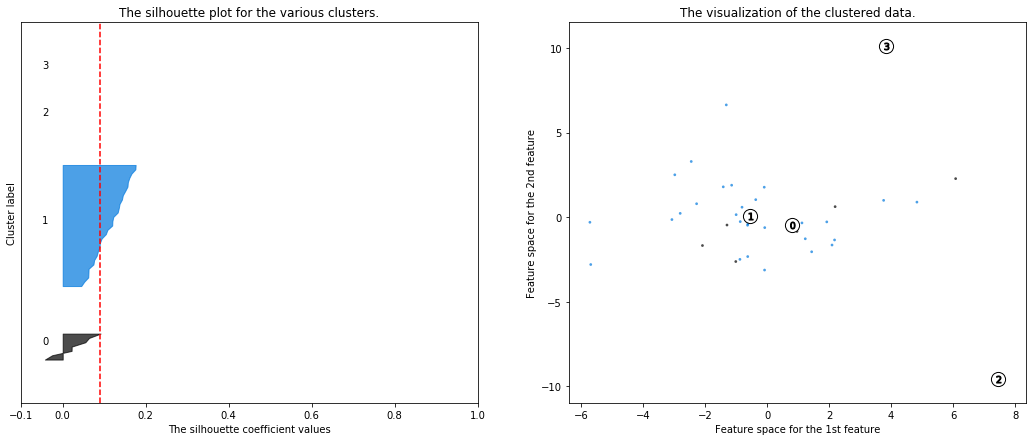

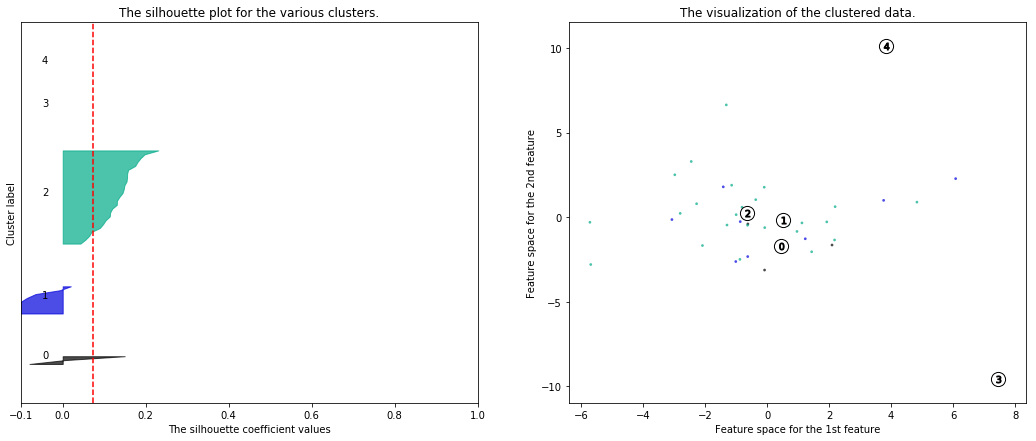

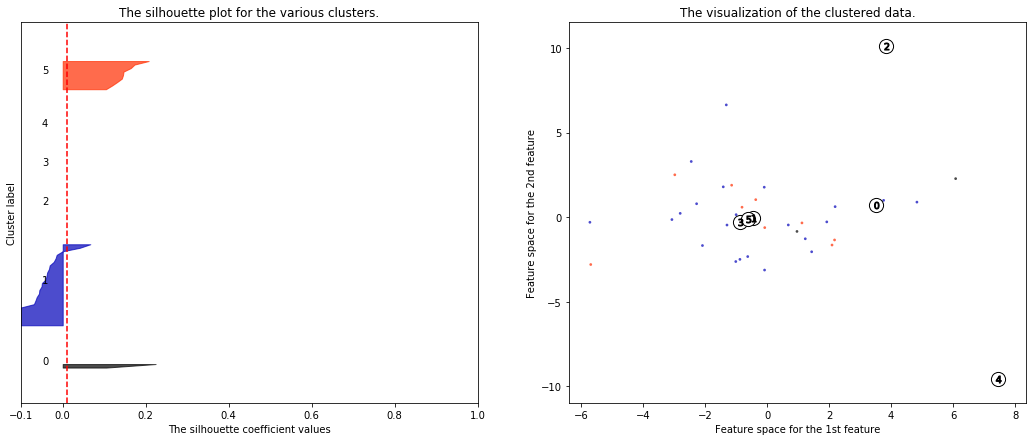

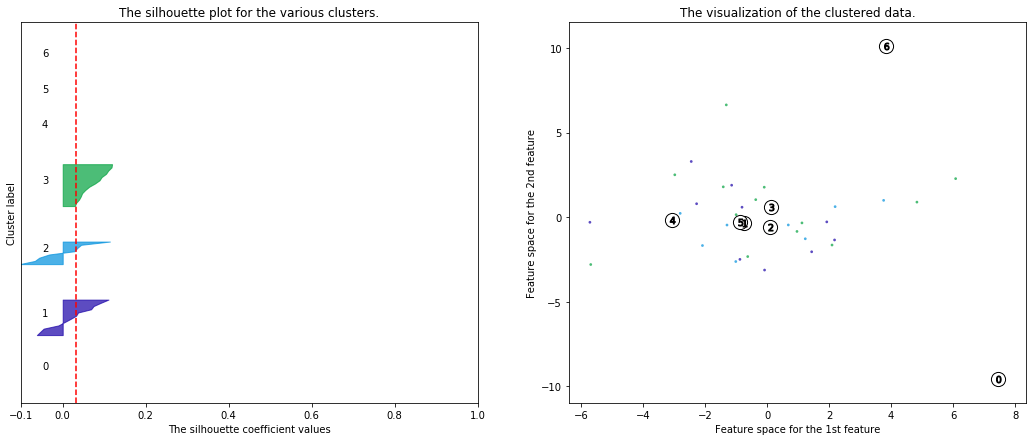

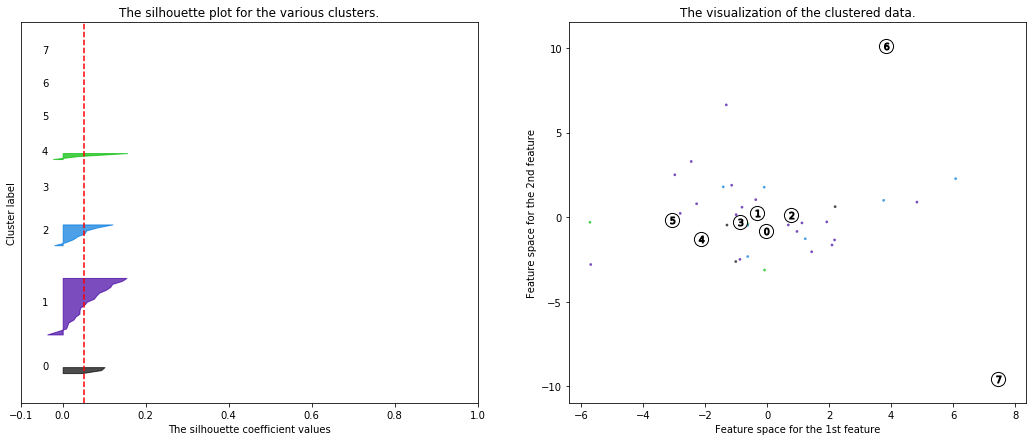

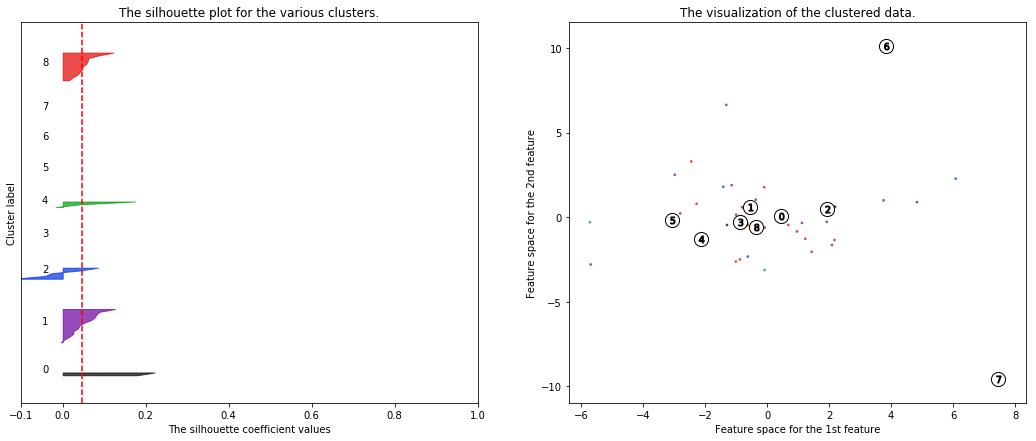

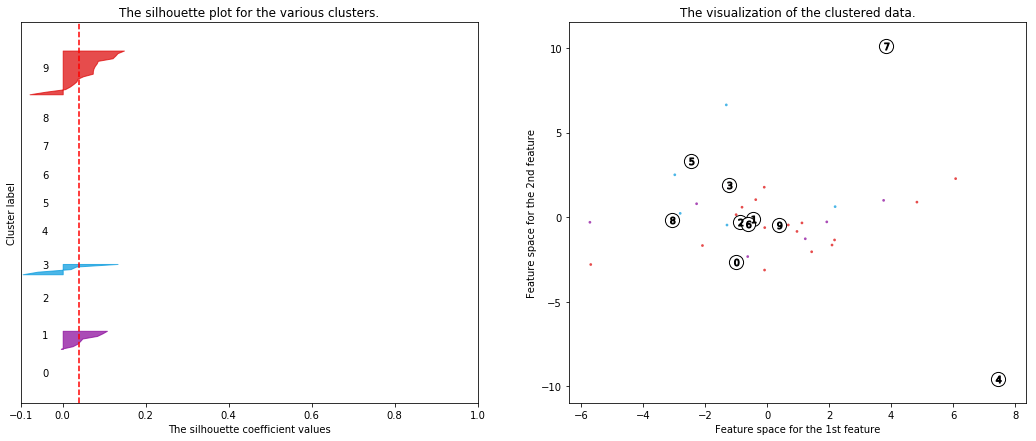

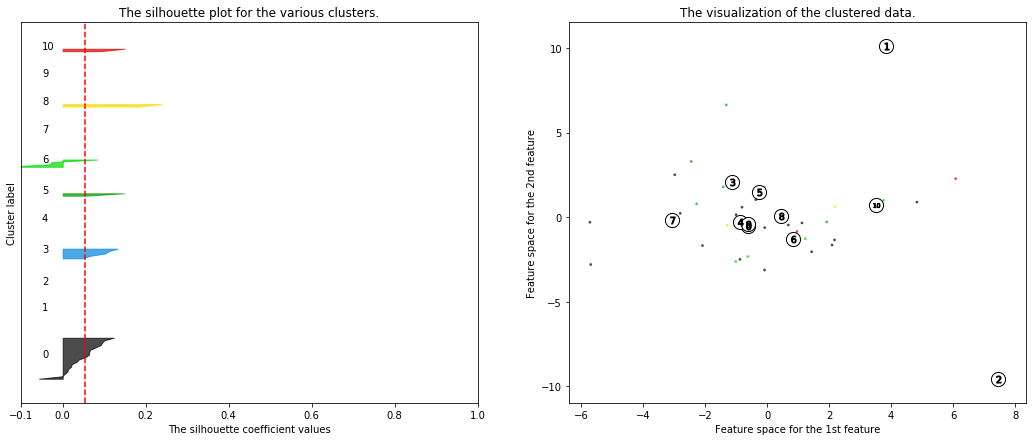

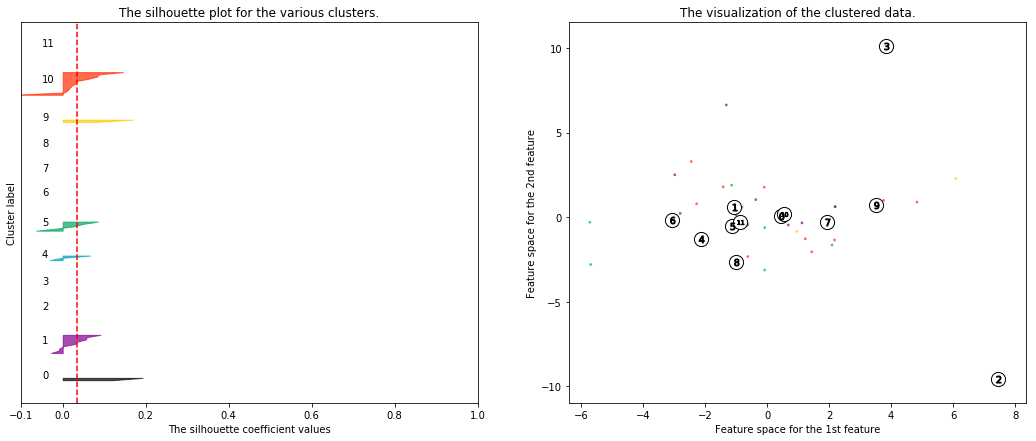

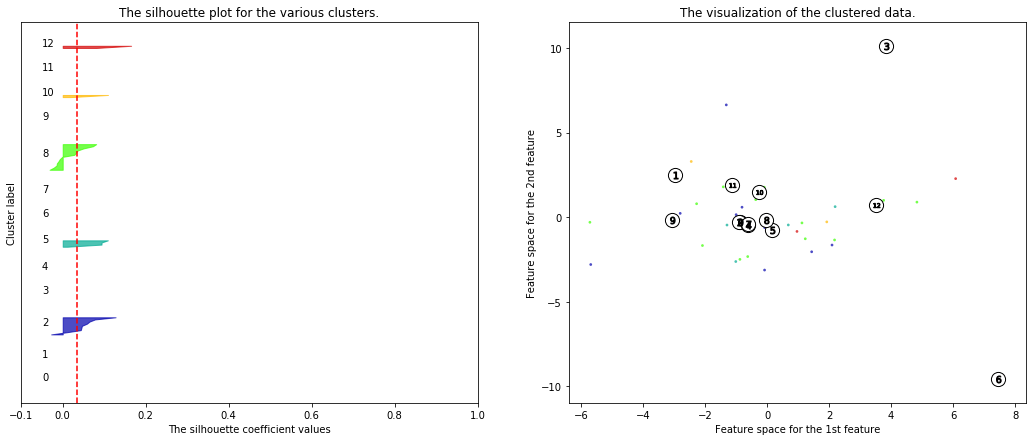

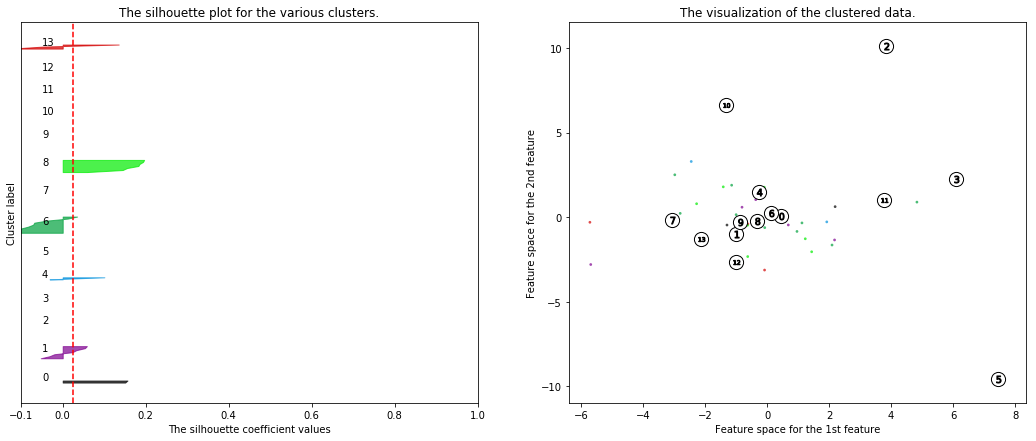

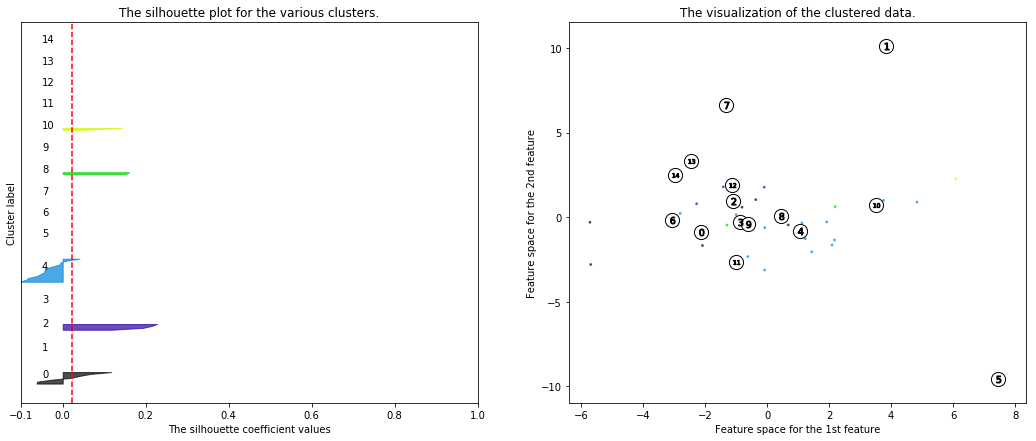

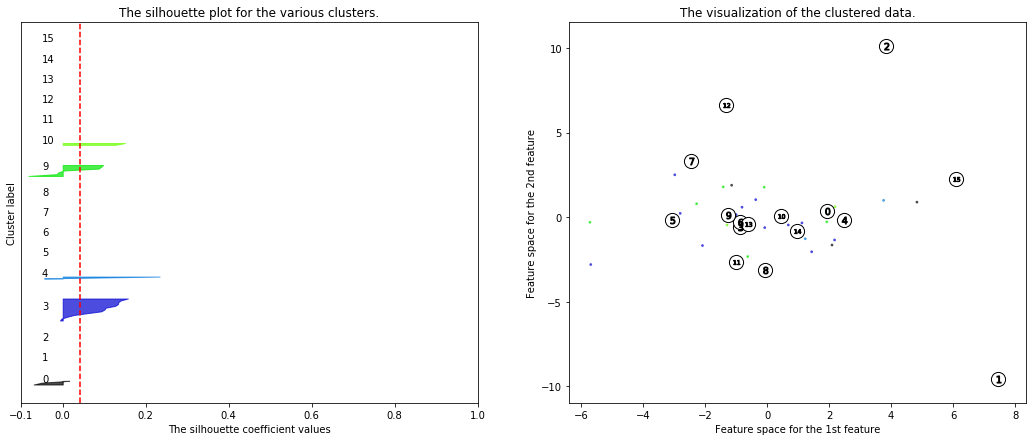

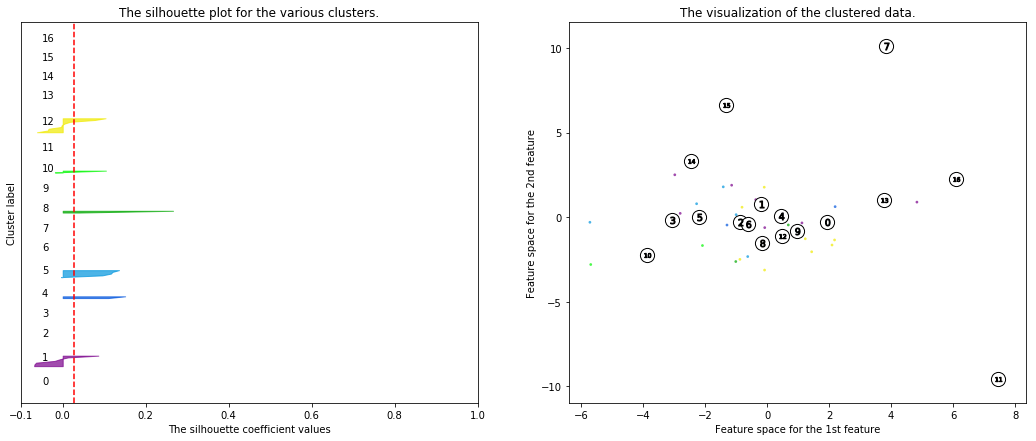

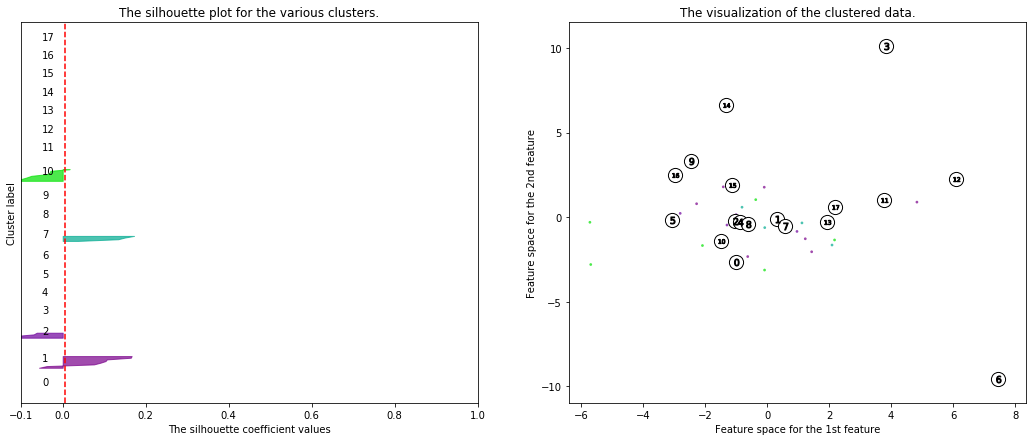

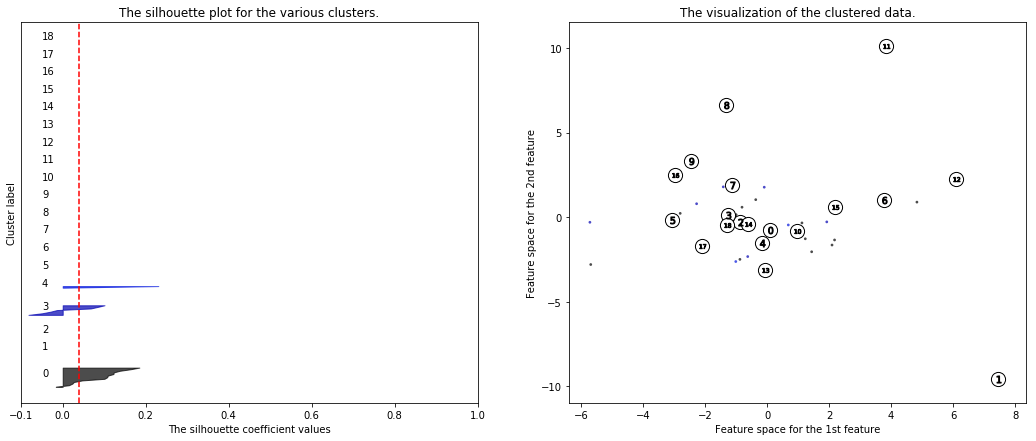

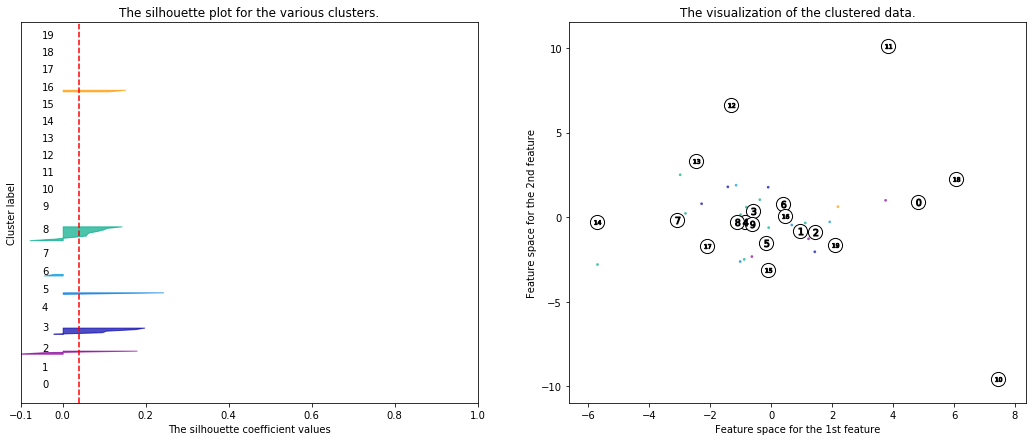

In [153]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
range_n_clusters = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_embedded) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=0, algorithm="full")
    cluster_labels = clusterer.fit_predict(X_embedded)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_embedded, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_embedded, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_embedded[:, 0], X_embedded[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")


plt.show()

4. Neighborhood Exploration and Clustering

   run *k*-means to cluster the neighborhood into 5 clusters.

In [154]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=10, algorithm="full").fit(X_embedded)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 2, 0, 2, 0, 3, 2, 3, 3, 3, 2, 2, 2, 2, 1, 3, 2, 0, 0, 2, 2, 2,
       2, 2, 3, 4, 3, 3, 2, 0, 2, 3, 0, 2, 3, 2, 2, 0], dtype=int32)

In [155]:
neighborhoods_venues_sorted.set_index('Neighborhood').reset_index().rename(columns={'Neighborhood': 'Neighbourhood'}).head()

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,3,Coffee Shop,Cocktail Bar,Cheese Shop,Bakery,Steakhouse,Seafood Restaurant,Café,Farmers Market,Beer Bar,Eastern European Restaurant
1,Business Reply Mail Processing Centre 969 Eastern,3,Light Rail Station,Yoga Studio,Auto Workshop,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Park,Comic Shop,Recording Studio
2,Central Bay Street,3,Coffee Shop,Ice Cream Shop,Italian Restaurant,Sandwich Place,Burger Joint,Café,Chinese Restaurant,Salad Place,Bubble Tea Shop,Restaurant
3,"Chinatown, Grange Park, Kensington Market",3,Café,Vegetarian / Vegan Restaurant,Chinese Restaurant,Bakery,Vietnamese Restaurant,Mexican Restaurant,Dumpling Restaurant,Bar,Coffee Shop,Park
4,Christie,3,Café,Grocery Store,Park,Diner,Convenience Store,Baby Store,Restaurant,Italian Restaurant,Nightclub,Coffee Shop


In [ ]:
# add clustering labels
try:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
except:
    pass

neighborhoods_venues_sorted['Cluster Labels'] = kmeans.labels_

toronto_merged = df_tor

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

#### Visualize resulting clustering

In [120]:
import matplotlib.colors as colors


# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Result and Discussion <a name="results"></a>

The clusters cluster locations with similar factors such as venues and geo locations. This could be a good guide for venue owner to choose opening places. For example, if you want to open some venue at places people may like to go to but not places that already full of same kind of venue, you could use this clustering. More specifically, for cluster 1, places are clustered together because they are geologically close and have similar distribution of venues, and sushi restaurant are most common venues in place 2 and 4. Thus, place 1 and 3 are great places to open sushi restaurant because they are similar based on geo location and venue distribution but there aren’t so many sushi restaurants there yet and therefore a newly opened sushi restaurant may be popular there.

#### Clustering 1

In [121]:
clusteringone = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]


In [122]:
clusteringone[clusteringone.columns[:5]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
19,East Toronto,0,Health Food Store,Trail,Pub
54,East Toronto,0,Café,Coffee Shop,Bakery
97,Downtown Toronto,0,Coffee Shop,Café,Hotel


#### Clustering 2

In [123]:
cluster2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]


In [124]:
cluster2[cluster2.columns[:5]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
2,Downtown Toronto,1,Coffee Shop,Park,Pub
9,Downtown Toronto,1,Coffee Shop,Clothing Store,Cosmetics Shop
30,Downtown Toronto,1,Coffee Shop,Café,Bar
36,Downtown Toronto,1,Coffee Shop,Hotel,Aquarium
43,West Toronto,1,Breakfast Spot,Café,Coffee Shop
69,West Toronto,1,Café,Mexican Restaurant,Bookstore
73,Central Toronto,1,Sporting Goods Shop,Coffee Shop,Clothing Store
81,West Toronto,1,Coffee Shop,Café,Sushi Restaurant
83,Central Toronto,1,Playground,Gym,Restaurant
91,Downtown Toronto,1,Park,Playground,Trail


#### Clustering 3

In [125]:
cluster3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]


In [126]:
cluster3[cluster3.columns[:5]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
61,Central Toronto,2,Park,Bus Line,Dim Sum Restaurant


#### Clustering 4

In [127]:
cluster4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

In [128]:
cluster4[cluster4.columns[:5]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
15,Downtown Toronto,3,Hotel,Italian Restaurant,Restaurant
20,Downtown Toronto,3,Coffee Shop,Cocktail Bar,Cheese Shop
24,Downtown Toronto,3,Coffee Shop,Ice Cream Shop,Italian Restaurant
25,Downtown Toronto,3,Café,Grocery Store,Park
31,West Toronto,3,Bakery,Pharmacy,Supermarket
37,West Toronto,3,Bar,Coffee Shop,Asian Restaurant
41,East Toronto,3,Greek Restaurant,Coffee Shop,Italian Restaurant
42,Downtown Toronto,3,Coffee Shop,Café,Hotel
47,East Toronto,3,Pizza Place,Fast Food Restaurant,Italian Restaurant
48,Downtown Toronto,3,Coffee Shop,Café,Hotel


#### Clustering 5

In [129]:
cluster5 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

In [130]:
cluster5[cluster5.columns[:5]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
62,Central Toronto,4,Garden,Women's Store,Flea Market


## Conclusion  <a name="conclusion"></a>

This capstone project focus on using cluster modeling to fit the location data and find out the most popular venues around each location. Then using the clustered information make business decisions such as which location is the best location to start a specific restaurant business.
By using Wikipedia website data obtain the location information in Toronto and using Foursquare API to obtains venues information. Transforming the data to pandas data frame, then applying the cleaned data to fit the k-means clustering model. I obtained top 10 most common venues for each cluster as shown above.
According to the result, I found for starting a new restaurant: First we have to choose a location which did not contain lots of restaurant. Then the restaurant category should be noticed by avoiding duplicate restaurant. Moreover, we can start new restaurant business by looking up similar nearby environment such as same clustering information.
Thus, k-means cluster modeling can be used very widely when facing such problem.
